# **K-Nearest Neighbors - rice_ml**
This notebook demonstrates how to use the KNNClassifier and KNNRegressor classes within the rice_ml package. It demonstrates them in an informative way that also analyzes the results, mirroring a standard use case of the classes.

Note that when using this in robust model selection, k-fold cross-validation and deeper hyperparameter tuning is recommended. In this example, since it's main goal is demonstrating the classes, we will not do as deep of hyperparameter tuning, and will compare every test using the same random state (42).


The rice_ml KNN implementation can be used similarly to sklearn's interface, although it is entirely separate.

This notebook shows how to:
- Use 'KNNClassifier' and 'KNNRegressor' from 'rice_ml'
- Prepare and normalize data using 'rice_ml'
- Evaluate KNN on both classification and regression tasks

## Table of Contents
- [Algorithm](#algorithm)
- [Data Preparation](#data-preparation)
- [KNN Classification](#knn-classification)
  - [Model Training](#model-training)
  - [Results](#results)
- [KNN Regression](#knn-regression)
  - [Model Training](#model-training-1)
  - [Results](#results-1)

## Algorithm
K-Nearest Neighbors is a non-parametric, supervised learning algorithm. It can act as either a classifier or a regressor. It uses proximity of neighbors (other data points) to predict the class of a data point. Given k neighbors, the algorithm selects the class either uniformly (class of the majority of neighbors), or based on distance (applying a weight based on distance before deciding).
![KNN Graph Example](../images/knn_graph.png)
Source: [Geeks For Geeks](https://www.geeksforgeeks.org/machine-learning/k-nearest-neighbours/)

To compute distance between two points, the algorithm can use any kind of distance function. In this package, you can use either euclidean distance (l2) or manhattan distance (l1).

For example, if you are trying to decide what digit an image is, the algorithm will look at the k closest neighbors (most similar neighbors). If you are deciding uniformly, the algorithm will find the class with the majority out of the all of the neighbors, and predict that class for the data point in question. 

### Pros vs Cons
#### Pros
- Simple and intuitive
- No training needed
- Flexibile decision boundaries (model can be complex and non-linear with no issues)
- Handles multi-class classification
#### Cons
- Can be slow (has to compute a lot of distances)
- Large memory overhead (must store entire training set)
- Can be sensitive to noise

## Data Preparation
We will be using the MNIST digits dataset. It is a widely used benchmark for image classification. It contains 70,000 grayscale images of handwritten digits (0-9). Each image is 28x28 pixels.
For sake of runtime, we will be using a random 10,000 data point sample from the dataset.

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from rice_ml.utilities import normalize, train_test_split

np.random.seed(42)

X_raw, y_raw = fetch_openml(
    "mnist_784",
    version=1,
    return_X_y=True,
    as_frame=False
)

## MNIST is a massive digits dataset, so we are taking a random sample of it.
rng = np.random.default_rng(42)
idxs = np.arange(len(X_raw))
rng.shuffle(idxs)

idxs = idxs[:10000]

X_raw = X_raw[idxs]
y_raw = y_raw[idxs]

X shape: (10000, 784)
y shape: (10000,)
X Overall Summary:
Min: 0.000
Max: 1.000
Mean: 0.132
Std: 0.309
Before normalization:
Mean (first 5 features): [0. 0. 0. 0. 0.]
Std  (first 5 features): [0. 0. 0. 0. 0.]
Min  (first 5 features): [0. 0. 0. 0. 0.]
Max  (first 5 features): [0. 0. 0. 0. 0.]


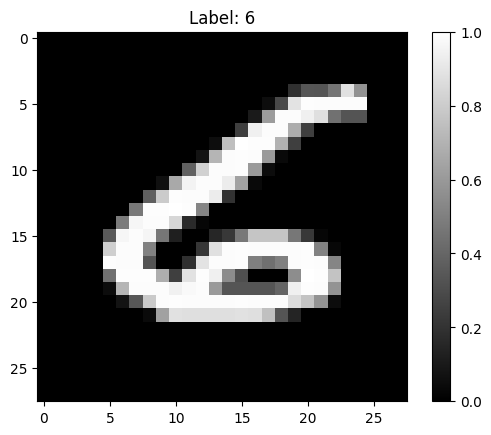

In [2]:
X = np.asarray(X_raw)
y = np.asarray(y_raw)

# Scaling
X = X / 255.0
y = y.astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)

print("X Overall Summary:")
print(f"Min: {X.min():.3f}")
print(f"Max: {X.max():.3f}")
print(f"Mean: {X.mean():.3f}")
print(f"Std: {X.std():.3f}")

print("Before normalization:")
print("Mean (first 5 features):", np.round(X.mean(axis=0)[:5], 2))
print("Std  (first 5 features):", np.round(X.std(axis=0)[:5], 2))
print("Min  (first 5 features):", X.min(axis=0)[:5])
print("Max  (first 5 features):", X.max(axis=0)[:5])

image = X[0].reshape(28, 28)

plt.imshow(image, cmap="gray")
plt.title(f"Label: {y[0]}")
plt.colorbar()
plt.show()

## KNN Classification
### Model Training

Above we can see some useful information for the dataset, plus a visualization of the first image in the data. We will now run the KNN classifier on it, and then attempt improvements using normalization.

KNN Classification Accuracy: 0.950


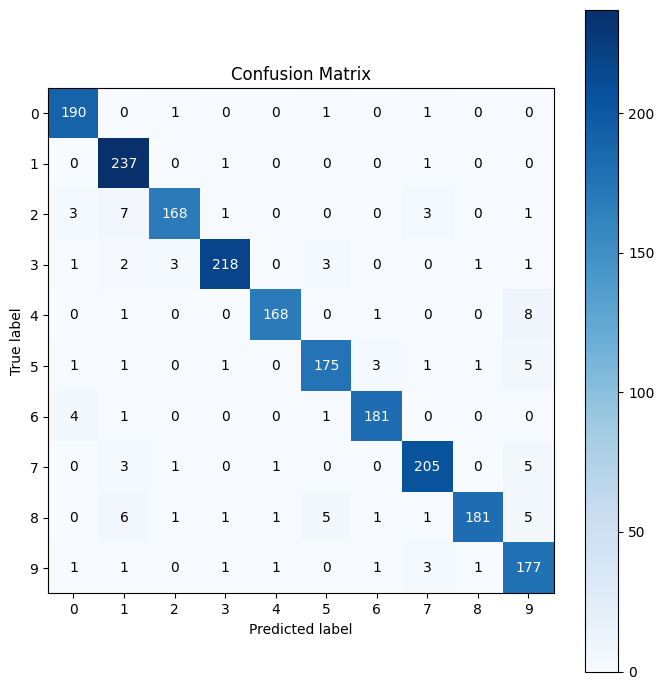

In [3]:
from rice_ml.supervised_learning.knn import KNNClassifier
from rice_ml.utilities import confusion_matrix, plot_confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

model = KNNClassifier(n_neighbors=5, distance='euclidean', weights='distance')

model.fit(X_train, y_train)

results = model.predict(X_test)
accuracy = model.score(X_test, y_test)

print(f"KNN Classification Accuracy: {accuracy:.3f}")
cm = confusion_matrix(y_test, results, num_classes=10)
plot_confusion_matrix(cm, class_labels=list(range(10)))


This already generates a great accuracy. A 95% accuracy is a really great start, even without normalizing. As we can see in the confusion matrix, all of the digits perform very well, with few issues.

#### Effect of num_neighbors on Model Performance

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

nn = [1, 3, 5, 7, 9, 11, 13, 15]

for n in nn:
    model = KNNClassifier(
        n_neighbors=n,
        distance="euclidean",
        weights="distance",
    )

    results = model.fit(X_train, y_train)
    score = model.score(X_test, y_test)

    print(f"KNN Accuracy (n_neighbors={n}): {score:.3f}")


KNN Accuracy (n_neighbors=1): 0.953
KNN Accuracy (n_neighbors=3): 0.950
KNN Accuracy (n_neighbors=5): 0.950
KNN Accuracy (n_neighbors=7): 0.948
KNN Accuracy (n_neighbors=9): 0.945
KNN Accuracy (n_neighbors=11): 0.944
KNN Accuracy (n_neighbors=13): 0.940
KNN Accuracy (n_neighbors=15): 0.939


As we can see, there is some variability depending on what n_neighbors we use, but everything we looked at performs very well still. We will use n_neighbors=5 going forwards.

#### Z-Score Normalization

After zscore normalization:
Mean (first 5 features): [0. 0. 0. 0. 0.]
Std  (first 5 features): [0. 0. 0. 0. 0.]
Min  (first 5 features): [0. 0. 0. 0. 0.]
Max  (first 5 features): [0. 0. 0. 0. 0.]


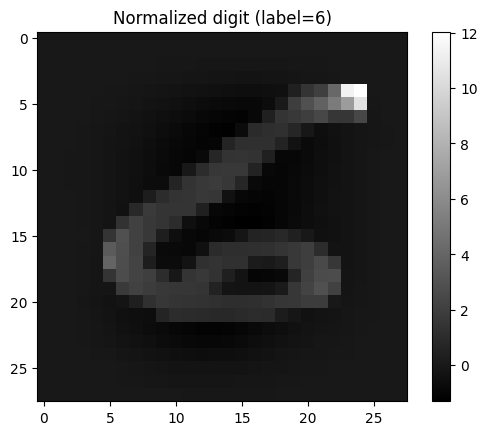

In [5]:
X = np.asarray(X)
X_norm = normalize(X, method="zscore")

print("After zscore normalization:")
print("Mean (first 5 features):", np.round(X_norm.mean(axis=0)[:5], 2))
print("Std  (first 5 features):", np.round(X_norm.std(axis=0)[:5], 2))
print("Min  (first 5 features):", np.round(X_norm.min(axis=0)[:5], 2))
print("Max  (first 5 features):", np.round(X_norm.max(axis=0)[:5], 2))

image_norm = X_norm[0].reshape(28, 28)

plt.imshow(image_norm, cmap="gray")
plt.title(f"Normalized digit (label={y[0]})")
plt.colorbar()
plt.show()

This normalization makes the image look darker, so it may be less well-defined. Let's see how the model does.

KNN Classification Accuracy: 0.920


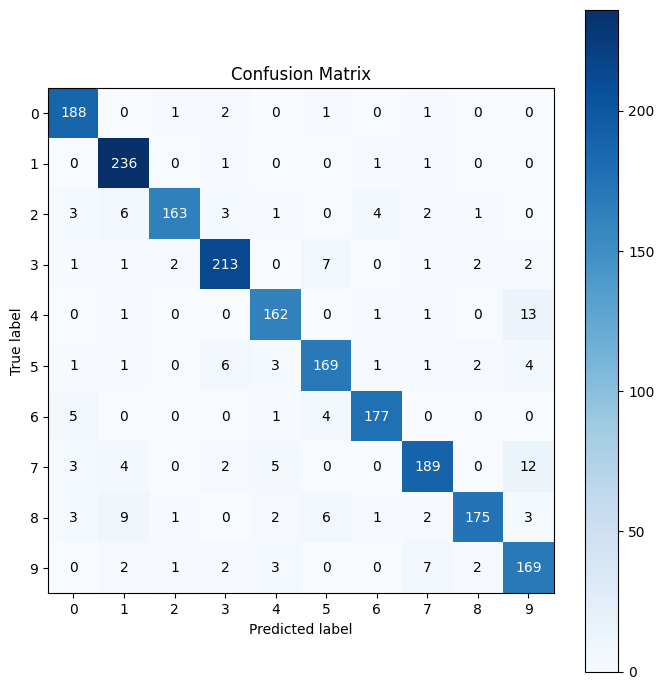

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Normalize on the training data to avoid data leakage.
X_train, stats = normalize(X_train, method="zscore", return_stats=True)
X_test = normalize(X_test, method="zscore", stats=stats)

model = KNNClassifier(n_neighbors=5, distance='euclidean', weights='distance')

model.fit(X_train, y_train)

results = model.predict(X_test)
accuracy = model.score(X_test, y_test)

print(f"KNN Classification Accuracy: {accuracy:.3f}")
cm = confusion_matrix(y_test, results, num_classes=10)
plot_confusion_matrix(cm, class_labels=list(range(10)))


The normalized image we looked at may have looked less clear after normalizing compared to before, and the model does perform worse than the base model, with an accuracy of 92%. We will try out an l2 normalization next.

#### L2 Normalization

After robust normalization:
Mean (first 5 features): [0. 0. 0. 0. 0.]
Std  (first 5 features): [0. 0. 0. 0. 0.]
Min  (first 5 features): [0. 0. 0. 0. 0.]
Max  (first 5 features): [0. 0. 0. 0. 0.]


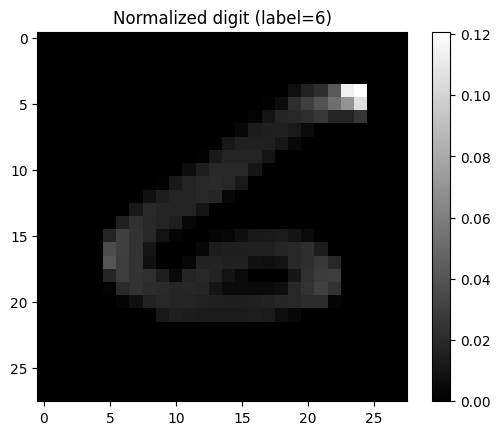

In [7]:
X = np.asarray(X)
X_norm = normalize(X, method="l2")

print("After robust normalization:")
print("Mean (first 5 features):", np.round(X_norm.mean(axis=0)[:5], 2))
print("Std  (first 5 features):", np.round(X_norm.std(axis=0)[:5], 2))
print("Min  (first 5 features):", np.round(X_norm.min(axis=0)[:5], 2))
print("Max  (first 5 features):", np.round(X_norm.max(axis=0)[:5], 2))

image_norm = X_norm[0].reshape(28, 28)

plt.imshow(image_norm, cmap="gray")
plt.title(f"Normalized digit (label={y[0]})")
plt.colorbar()
plt.show()

KNN Classification Accuracy: 0.893


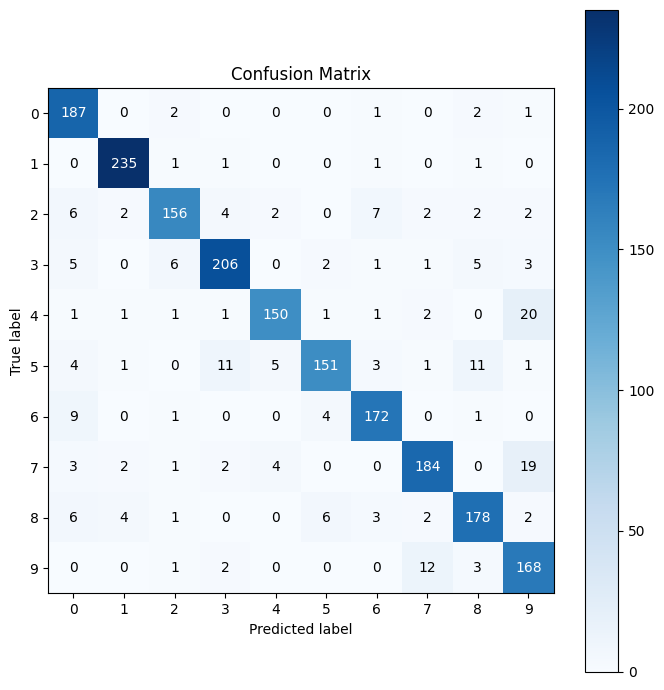

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# No need to normalize on the training data - l2 is stateless, so there is no data leakage.
X_train = normalize(X_train, method="l2")
X_test  = normalize(X_test, method="l2")

model = KNNClassifier(n_neighbors=5, distance='euclidean', weights='distance')

model.fit(X_train, y_train)

results = model.predict(X_test)
accuracy = model.score(X_test, y_test)

print(f"KNN Classification Accuracy: {accuracy:.3f}")
cm = confusion_matrix(y_test, results, num_classes=10)
plot_confusion_matrix(cm, class_labels=list(range(10)))


Using l2 normalization results in a 89.3% accuracy, underperforming against both the base model and the zscore normalized model.
This data is massive and has a lot of dimensions, so we are now going to apply PCA to the data and then see how the model performs. We will use our non-normalized data.

#### PCA

KNN Classification Accuracy: 0.950


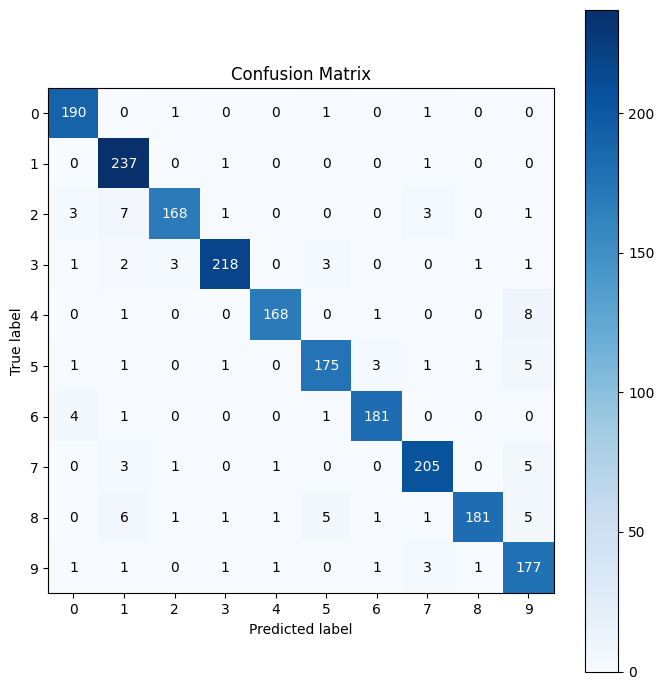

In [9]:
from rice_ml.unsupervised_learning.pca import PrincipalComponentAnalysis

X = np.asarray(X)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

pca = PrincipalComponentAnalysis(n_components=30)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

model = KNNClassifier(n_neighbors=5, distance='euclidean', weights='distance')

model.fit(X_train, y_train)

results = model.predict(X_test)
accuracy = model.score(X_test, y_test)

print(f"KNN Classification Accuracy: {accuracy:.3f}")
cm = confusion_matrix(y_test, results, num_classes=10)
plot_confusion_matrix(cm, class_labels=list(range(10)))


### Results
Accuracy:
- Base Model: 95.0%
- Zscore Norm: 92.0%
- L2 Norm: 89.3%
- PCA: 95.0%

Every test performed very well, with the base model and PCA performing the best. In a standard scenario, after confirming with hyperparameter tuning and cross-validation, it would likely be best to go with the base model, as simplicity is important in understanding the results.

#### Error Analysis

Looking at the confusion matrices, we can see that most of the errors occur between digits that look similar. There are noticeable patches of incorrect predictions when images of '4' are predicted as '9', and when images of '5' are predicted as '3'. Other than this, there are very few errors - this model performs exceptionally well.

## KNN Regression
We can also use KNN as a regressor. In this use, predictions are made by averaging the target house values of the k nearest neighbors. It can also add weights to the neighbors based on distance, just like the classifier.

### Data
We will be using the California Housing data from 'sklearn'. It contains census information about median housing prices in California districts. Given demographic and geographic features, we can use it to predict the median house value for a district.

In [10]:
from sklearn.datasets import fetch_california_housing
from rice_ml.supervised_learning.knn import KNNRegressor

data = fetch_california_housing()

X = data.data
y = data.target
feature_names = data.feature_names

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Features:", feature_names)


X shape: (20640, 8)
y shape: (20640,)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


### Model Training

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

model = KNNRegressor(
    n_neighbors=5,
    weights="distance",
    distance="euclidean",
)

model.fit(X_train, y_train)

r2 = model.score(X_test, y_test)
print(f"R2 score: {r2:.3f}")

y_pred = model.predict(X_test)

mse = ((y_test - y_pred) ** 2).mean()
print(f"RMSE: {np.sqrt(mse):.3f}")

R2 score: 0.195
RMSE: 1.041


This model has a poor R^2 score, not predicting much more accurate than random. The model explains less than 20% of the variance. The RMSE is also not great, but could be much worse. It is in terms of $100k, so it is showing the average error at around $104,000. We will try a zscore normalization.

#### Z-Score Normalization

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Normalize on the training data to avoid data leakage.
X_train, stats = normalize(X_train, method="zscore", return_stats=True)
X_test = normalize(X_test, method="zscore", stats=stats)

model = KNNRegressor(
    n_neighbors=5,
    weights="distance",
    distance="euclidean",
)

model.fit(X_train, y_train)

r2 = model.score(X_test, y_test)
print(f"R2 score: {r2:.3f}")

y_pred = model.predict(X_test)

mse = ((y_test - y_pred) ** 2).mean()
print(f"RMSE: {np.sqrt(mse):.3f}")

R2 score: 0.698
RMSE: 0.637


### Results
This is a significant improvement to the model. It is now predicting around 64% of the variance, which is very good for this dataset. The RMSE also improved, showing the average error at around $64,000.

## Conclusion
Overall, we can see that KNN works very well as both a classifier and a regressor. While it works much better for some types of data over others, it is a great option and a great starting point when starting to compare models.